In [1]:
import dask
from dask.distributed import Client
from dask.distributed import fire_and_forget
import dask_jobqueue
import discretize
from discretize.utils import mkvc
# import deepdish as dd
import h5py
import json
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp

import casingSimulations as casing_sim
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from pymatsolver import Pardiso

np.random.seed(29)
%matplotlib inline

In [2]:
dask_jobqueue.__version__

'0.7.0'

In [3]:
directory = "experiment1"

if not os.path.isdir(directory):
    os.makedirs(directory, exist_ok=True)

In [4]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [5]:
nsamples = 2**4
print(nsamples)

16


In [6]:
#### set bounds for the distributions of 
sigma_background_bounds = np.r_[1e-4, 1]
sigma_casing_bounds = np.r_[1e4, 1e7]

d_casing_bounds = np.r_[5e-2, 30e-2]
t_casing_bounds = np.r_[5e-3, 2e-2]
l_casing_bounds = np.r_[500, 4e3]

In [7]:
# constants
sigma_air = 1e-4
sigma_inside = 1  # fluid inside the casing
mur_casing = 1  # permeability is the same as free space

src_a = np.r_[0., 0., 0.]  # the radius will be updated to connect to the casing
src_b = np.r_[1000., 0, 0]

csz = 5  # cell-size in the z-direction
csx_casing = 5e-3
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [8]:
def generate_random_variables(bounds, n_samples, sig_digs=None):
    min_value = bounds.min()
    max_value = bounds.max()
    v = np.random.rand(n_samples)
    v = min_value + (v*(max_value - min_value))
    if sig_digs is not None:
        v = np.round((v*10**(sig_digs)))/10**(sig_digs)
    return v

In [9]:
log10_sigma_background_dist = generate_random_variables(np.log10(sigma_background_bounds), nsamples, 2)
log10_sigma_casing_dist = generate_random_variables(np.log10(sigma_casing_bounds), nsamples, 2)

d_casing_dist = generate_random_variables(d_casing_bounds/csx_casing, nsamples, 0) * csx_casing 
t_casing_dist = generate_random_variables(t_casing_bounds/csx_casing, nsamples, 0) * csx_casing 
l_casing_dist = generate_random_variables(l_casing_bounds/csz, nsamples, 0) * csz # generate by ncells

parameters = {
    "log10_sigma_background":log10_sigma_background_dist,
    "log10_sigma_casing":log10_sigma_casing_dist,
    "log10_sigma_air":np.log10(sigma_air),
    "d_casing":d_casing_dist,
    "t_casing":t_casing_dist,
    "l_casing":l_casing_dist,
    "mur_casing":mur_casing,
}

In [10]:
df = pd.DataFrame(parameters)
df

,log10_sigma_background,log10_sigma_casing,log10_sigma_air,d_casing,t_casing,l_casing,mur_casing
0,-0.54,4.86,-4.0,0.170,0.010,2260.0,1
1,-2.86,6.05,-4.0,0.215,0.020,1870.0,1
2,-3.71,6.52,-4.0,0.070,0.015,3915.0,1
3,-0.95,6.43,-4.0,0.215,0.005,630.0,1
4,-2.19,4.00,-4.0,0.175,0.010,1110.0,1
5,-1.83,6.77,-4.0,0.240,0.015,1845.0,1
6,-1.09,6.42,-4.0,0.155,0.020,2265.0,1
7,-0.60,6.87,-4.0,0.130,0.005,1795.0,1
8,-0.93,5.45,-4.0,0.170,0.010,3235.0,1
9,-1.07,5.99,-4.0,0.280,0.015,3095.0,1


In [11]:
df.to_hdf(f"{directory}/trial_data.h5", 'data') #for key in df.keys()

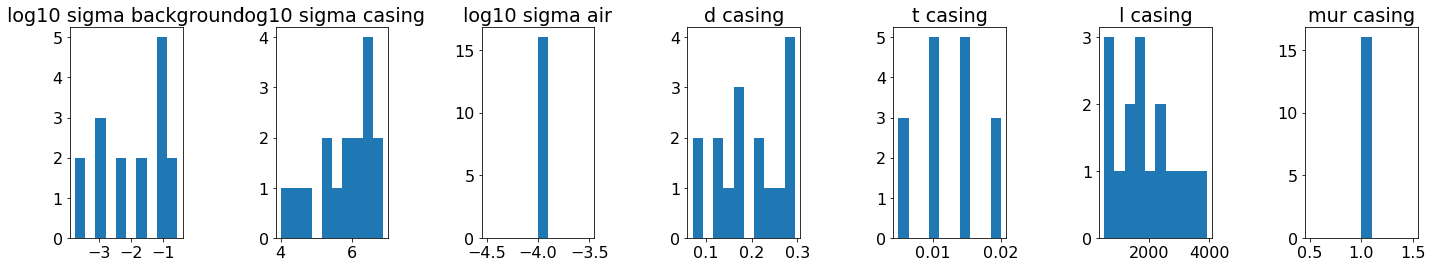

In [12]:
fig, ax = plt.subplots(1,len(parameters.keys()), figsize=(20, 4))

for i, key in enumerate(parameters.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [13]:
def generate_models(
    i, directory, src_a=np.r_[0., 0., 0.], src_b=np.r_[1000., 0., 0.],
):
    import casingSimulations as casing_sim
    
    df = pd.read_hdf(f"{directory}/trial_data.h5", "data", start=i, stop=i+1).iloc[0]
    
    # create the trial directory if it doesn't exist
    trial_directory = f"{directory}/trial_{i}"
    if not os.path.isdir(trial_directory):
        os.makedirs(trial_directory, exist_ok=True)

    # create the model 
    model = casing_sim.model.CasingInHalfspace(
        directory=trial_directory,
        casing_d = df["d_casing"] - df["t_casing"],  # I use diameter to the center of the casing wall
        casing_l = df["l_casing"],
        casing_t = df["t_casing"], 
        mur_casing = df["mur_casing"],
        sigma_air = 10**df["log10_sigma_air"],
        sigma_casing = 10**df["log10_sigma_casing"],
        sigma_back = 10**df["log10_sigma_background"],
        sigma_inside = 10**df["log10_sigma_background"],
        src_a = src_a,
        src_b = src_b,
#         timeSteps = time_steps
    )
    model.filename = "casing.json"
    
    sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
    
    model_approx_casing = model.copy()
    model_approx_casing.sigma_inside = sigmaA
    model_approx_casing.sigma_casing = sigmaA
    model_approx_casing.filename = "approx_casing.json"
    
    model.save()
    model_approx_casing.save()
#     return model.filename, model_approx_casing.filename
    return model, model_approx_casing

In [14]:
def run_simulation(
    model, trial_directory, name, csx1=5e-3, 
    csz=5, nhy=12, csx2=100, padding_extent=1e4, # mesh parameters
    pfx2=1.5, pfz=1.5,
    time_steps=[(1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 15)], 
):
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
#     from pyMKL import mkl_set_num_threads
#     mkl_set_num_threads(1)
    
    # load up the model
#     with open(f"{trial_directory}/{model}") as f:
#         params = json.load(f)
#     model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)
    
    # generate the mesh
    hy = np.ones(nhy)
    hy = hy*2*np.pi / hy.sum()
    
    # esure padding goes sufficiently far in the x direction
    npad_x = 0
    npad_z = 0
    pfx2 = 1.5
    pfz = 1.5
    padding_x = model.casing_l
    padding_z = model.casing_l
    
    while padding_x < padding_extent:
        npad_x += 1
        padding_x = model.casing_l + np.sum((csx2 * (np.ones(npad_x)*pfx2)**np.arange(1, npad_x+1)))
    
    while padding_z < padding_extent:
        npad_z += 1
        padding_z = model.casing_l + np.sum((csz * (np.ones(npad_z)*pfz)**np.arange(1, npad_z+1)))
    
    meshGen = casing_sim.mesh.CasingMeshGenerator(
        modelParameters = model, 
        csx1 = csx1,
        csx2 = csx2,
        domain_x = model.src_b[1],  # use 2.5m cells out to 300m. 
        hy = hy,
        npadx = npad_x, # 6
        npadz = npad_z,  #14
        csz = csz,
        _ncx1 = np.ceil(model.casing_b / csx1),
    )
    mesh = meshGen.mesh
    
    # generate the survey
    src_theta = np.pi/2. + mesh.hy[0]/2.
    model.src_a[1] = src_theta
    model.src_b[1] = src_theta
    
    src_top = casing_sim.sources.TopCasingSrc(
        modelParameters=model, 
        meshGenerator=meshGen,
        src_a=model.src_a,
        src_b=model.src_b,
        physics="TDEM",
        filename="top_casing",
    )

    source_list = src_top.srcList
    survey = tdem.Survey(source_list)
    
    # generate the simulation
    sim = tdem.Problem3D_j(
        mesh=mesh, survey=survey, solver=Pardiso, time_steps=time_steps
    )
    
    filename = f"{trial_directory}/simulation_{name}.json"
    with open(filename, 'w') as outfile:
        json.dump(sim.serialize(), outfile)
    
    sim.sigmaMap = maps.IdentityMap(sim.mesh)
    m = model.sigma(sim.mesh)
    
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]

    filename = f"{name}_fields.npy"
    tosave = os.path.sep.join([trial_directory, filename]) 
    print(f"saving {tosave}")
    np.save(tosave, f)
    
    return f
    
#     return filename

In [15]:
def compute_casing_currents(
    currents, trial_directory, 
    ndata=32, ntimes=128,
    xmin=5, xmax=None,
    log10tmin=-6, log10tmax=-2
):
    import numpy as np
    from discretize.utils import mkvc
    import discretize
    from SimPEG.electromagnetics import time_domain as tdem 
    import casingSimulations as casing_sim
    import json
    import scipy.sparse as sp
    
#     print(f"computing casing currents: {fields_files}, {trial_directory}")
    
    with open(f"{trial_directory}/casing.json") as f: 
        params = json.load(f)
    model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)
    
    with open(f"{trial_directory}/simulation_casing.json") as f:
        simulation_params = json.load(f)
    
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)

    if xmax is None:
        xmax = model.casing_l
    xsample = np.linspace(xmin, xmax, ndata)
    zsample = np.linspace(-model.casing_l, 0, ndata)
    xz_grid = discretize.utils.ndgrid(xsample, np.r_[0], zsample)
    tsample = np.logspace(log10tmin, log10tmax, ntimes)
    
    np.save(f"{trial_directory}/x.npy", xsample)
    np.save(f"{trial_directory}/z.npy", zsample)

    mesh = sim.mesh
        
    # compute jd
    jd = currents["casing"] - currents["approx_casing"]
    
    jdx = mkvc(jd[:mesh.vnF[0], :]).reshape(tuple(mesh.vnFx)+(sim.nT+1,), order="F")
    jdz = mkvc(jd[np.sum(mesh.vnF[:2]):, :]).reshape(tuple(mesh.vnFz)+(sim.nT+1,), order="F")

    # take mean in theta-dimension jdx.mean(1)
    jdx = jdx.mean(1)
    jdz = jdz.mean(1)

    jdxz = np.hstack([mkvc(jdx), mkvc(jdz)])
    
    mesh2d = discretize.CylMesh([sim.mesh.hx, 1, mesh.hz], x0=mesh.x0)
    Px = mesh2d.getInterpolationMat(xz_grid, 'Fx')
    Pz = mesh2d.getInterpolationMat(xz_grid, 'Fz')
    Pt = sim.time_mesh.getInterpolationMat(tsample, 'N')

    Pxt = sp.kron(Pt, Px)
    Pzt = sp.kron(Pt, Pz)
    P = sp.vstack([Pxt, Pzt])

    jdata = P * jdxz
    np.save(f"{trial_directory}/j_difference.npy", jdata)
    
    # compute current inside casing
    ind_casing = model.ind_casing(mesh) + model.ind_inside(mesh)
    ind_casing_Fz = (mesh.aveFz2CC.T * ind_casing).astype(bool)

    I = discretize.utils.sdiag(mesh.area) * currents["approx_casing"]
    Iz = I[mesh.vnF[:2].sum():, :]
    Iz[~ind_casing_Fz, :] = 0
    Iz = Iz.reshape(tuple(mesh.vnFz) + (sim.nT+1,), order="F")
    Iz_casing = (Iz.sum(0)).sum(0)
    
    np.save(f"{trial_directory}/I_casing.npy", Iz_casing)
    return True

In [16]:
def run_trial(i):
    models = dask.delayed(generate_models)( 
        i, directory, src_a=np.r_[0., 0., 0.], src_b=np.r_[1000., 0., 0.],
    )
    
    trial_directory = f"{directory}/trial_{i}"
    time_steps = [(1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 20)]
    
    fields = {}
    for j, name in enumerate(["casing", "approx_casing"]): 
        fields[name] = dask.delayed(run_simulation)(
            models[j], trial_directory, name, time_steps=time_steps
        )
        
    currents = dask.delayed(compute_casing_currents)(
        fields, trial_directory, 
        ndata=32, ntimes=128,
        xmin=5,
        log10tmin=-6, log10tmax=-2
    )
    return currents

In [17]:
output = []
for i in range(nsamples):
    out = run_trial(i)
    output.append(out)
    
# output

In [18]:
# cluster = dask_jobqueue.SLURMCluster(
#     cores=2*nsamples,
#     processes=nsamples*2, 
#     memory=f"{nsamples*62}GB", 
#     project="m3384",
#     job_extra = ['--constraint=haswell', '--qos=regular'], 
#     death_timeout=360,
#     nodes=np.ceil(nsamples*2/32),
# #     job_cpu=nsamples, 
# )

cluster = dask_jobqueue.SLURMCluster(
    cores=8,
    processes=8, 
    memory=f"120GB", 
    project="m3384",
    job_extra = ['--constraint=haswell', '--qos=regular'], 
    death_timeout=360,
    walltime="00:30:00"
#     job_cpu=nsamples, 
)

print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A m3384
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=112G
#SBATCH -t 00:30:00
#SBATCH --constraint=haswell
#SBATCH --qos=regular

JOB_ID=${SLURM_JOB_ID%;*}

/global/homes/l/lheagy/.conda/envs/simpeg37/bin/python -m distributed.cli.dask_worker tcp://128.55.224.49:43675 --nthreads 1 --nprocs 8 --memory-limit 15.00GB --name name --nanny --death-timeout 360



In [19]:
client = Client(cluster)
client

Client Scheduler: tcp://128.55.224.49:43675 Dashboard: http://128.55.224.49:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [20]:
cluster_size = int(np.floor(nsamples * 2 / 8))
cluster_size

4

In [21]:
cluster.scale(cluster_size)

In [29]:
# client = Client(threads_per_worker=1, n_workers=4)
# client

In [ ]:
dask.compute(output)

In [ ]:
j_casing = np.load("./experiment1/trial_0/casing_fields.npy")
j_approx = np.load("./experiment1/trial_0/approx_casing_fields.npy")

In [ ]:
jd = j_casing-j_approx

In [ ]:
with open(f"./experiment1/trial_0/simulation_casing.json") as f:
    simulation_params = json.load(f)

sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
mesh = sim.mesh

In [68]:
def theta_index_mirror(theta_ind):
    return (
        theta_ind+int(mesh.vnC[1]/2)
        if theta_ind < int(mesh.vnC[1]/2)
        else theta_ind-int(mesh.vnC[1]/2)
    )

0.0


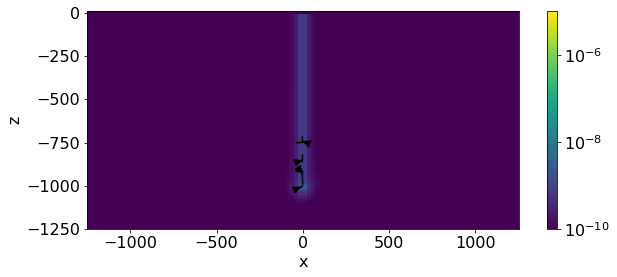

In [80]:
time_ind = 0
theta_ind = 3

plotme = jd[:, time_ind]
xlim = 1250*np.r_[-1, 1]
zlim = np.r_[-1250, 10]
clim = np.r_[1e-10, 1e-5]

print(sim.timeMesh.vectorNx[time_ind]*1e3)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

theta_ind_mirror = theta_index_mirror(theta_ind)
plt_vec = casing_sim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind)
mirror_data = casing_sim.utils.face3DthetaSlice(mesh, plotme, theta_ind=theta_ind_mirror)
plot_type = "vec"

mesh2D = discretize.CylMesh([mesh.hx, 1, mesh.hz], x0=mesh.x0)

out = casing_sim.view.plotFace2D(
    mesh2D, plt_vec, ax=ax, range_x=xlim, range_y=zlim,
    sample_grid=(
        np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]
#             if xlim is not None and zlim is not None else None
    ),
    log_scale=True,
    clim=clim,
    stream_threshold=clim[0] if clim is not None else None,
    mirror=True,
    mirror_data=mirror_data,
    stream_opts = {"color": "k", "arrowsize": 1.5, "density": 0.8}
)

ax.set_aspect(1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=sim.timeMesh.vectorCCx[0], vmax=sim.timeMesh.vectorNx[-1])
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for i in range(sim.nT):
    ax[0].plot(mesh.vectorNz, -Iz_casing[:, i], color=scalar_map.to_rgba(sim.timeMesh.vectorNx[i]+1e-7))
    ax[1].semilogy(mesh.vectorNz, np.abs(-Iz_casing[:, i]), color=scalar_map.to_rgba(sim.timeMesh.vectorNx[i]+1e-7))

for a in ax:
    a.set_xlim([5., -1.25*model.casing_l])
    a.grid(which="both", color="k", lw=0.4, alpha=0.4)

ax[1].set_ylim([1e-8, 1])

cb = plt.colorbar(scalar_map)
cb.set_label("time (s)")
plt.tight_layout()

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.


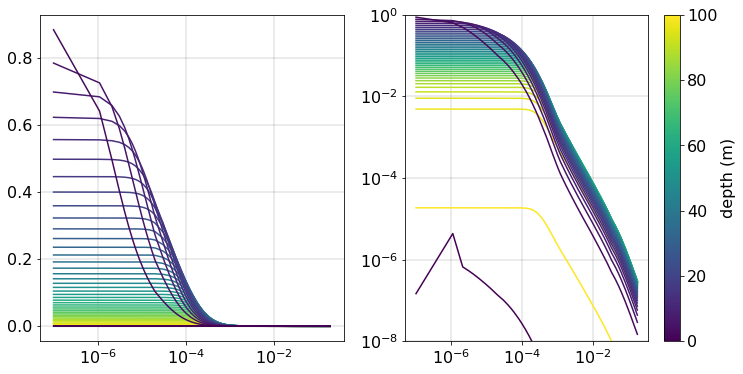

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cm = plt.get_cmap('viridis')
c_norm = Normalize(vmin=0, vmax=model.casing_l)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for i in range(mesh.vnFz[2]):
    ax[0].semilogx(sim.timeMesh.vectorNx+1e-7, -Iz_casing[i, :], color=scalar_map.to_rgba(-mesh.vectorNz[i]))
    ax[1].loglog(sim.timeMesh.vectorNx+1e-7, np.abs(-Iz_casing[i, :]), color=scalar_map.to_rgba(-mesh.vectorNz[i]))

for a in ax:
#     a.set_xlim([5., -1.25*model.casing_l])
    a.grid(which="both", color="k", lw=0.4, alpha=0.4)

ax[1].set_ylim([1e-8, 1])

cb=plt.colorbar(scalar_map)
cb.set_label("depth (m)")


In [164]:
n_z_currents = 128
z_sample = np.linspace(-model.casing_l, 0, n_z_currents)
Pz_casing_currents = discretize.TensorMesh([mesh.hz], [mesh.x0[2]]).getInterpolationMat(
    z_sample, 'N'
)

In [167]:
P_casing_currents = sp.kron(Pt, Pz_casing_currents)
I_casing_data = -1*P_casing_currents*discretize.utils.mkvc(Iz_casing)
np.save(f"{trial_directory}casing_currents.npy", I_casing_data)

In [16]:
dask_jobqueue.SLURMCluster?

Init signature:
dask_jobqueue.SLURMCluster(
    n_workers=0,
    job_cls: dask_jobqueue.core.Job = None,
    loop=None,
    security=None,
    silence_logs='error',
    name=None,
    asynchronous=False,
    interface=None,
    host=None,
    protocol='tcp://',
    dashboard_address=':8787',
    config_name=None,
    **kwargs,
)
Docstring:     
Launch Dask on a SLURM cluster

Parameters
----------
queue : str
    Destination queue for each worker job. Passed to `#SBATCH -p` option.
project : str
    Accounting string associated with each worker job. Passed to `#SBATCH -A` option.
cores : int
    Total number of cores per job
memory: str
    Total amount of memory per job
processes : int
    Cut the job up into this many processes.
    Good for GIL workloads or for nodes with many cores.
interface : str
    Network interface like 'eth0' or 'ib0'.
nanny : bool
    Whether or not to start a nanny process
local_directory : str
    Dask worker local directory for file spilling.
death_timeou